# Locality Sensitive Hashing

This notebook shows the implementation of the locality sensitive hashing algorithm, SimHash [1], and gives a convincing and randomized example show it works.

1. 1. Charikar, Moses S. "Similarity estimation techniques from rounding algorithms." Proceedings of the thiry-fourth annual ACM symposium on Theory of computing. ACM, 2002.

## Overview

The SimHash algorithm uses random hyperplanes to compute a hash for points. Given $n$ points in $\mathbb{R}^d$, we draw $k$ hyperplanes. These hyperplanes form a basis for a $k$ bit Hamming space. Points are encoded into this space by computing their relative position with respect to each hyperplane, e.g. by computing the sign of the dot product with the planes normal vector. Note that these encodings are not necessarily unique. Hashed object can then be compared by computing the Hamming distance of the encodings.

Formally, unit vectors $r_i$ are drawn uniformly at random from $\mathbb{R}^d$ which serve as the hyperplane normals. Then, the hash function $h_{r_i}(v)$ is defined as 

$$
h_{r_i}(v) = \begin{cases} 1 & v \cdot r_i \geq 0 \\ 0 & v \cdot r_i < 0 \end{cases}
$$

which gives one bit of the final hash.

For easy visualzation, we will demonstrate the algorithm on points in $\mathbb{R}^2$ and use only 16 bits. This is not enough to guarantee unique hashes for each point, but for the visualization that is OK. We begin with some boilerplate code

In [1]:
%matplotlib notebook

import lsh 
import numpy as np
from matplotlib import pyplot as plt

def plot_line(l):
    x1 = -10 
    x2 = 10
    y1 = l[0] * x1 / -l[1]
    y2 = l[0] * x2 / -l[1]
    
    plt.plot([x1, x2], [y1, y2], 'blue')
    
hash_bits = 16

## Generating a Basis

In order to compute the hash, we must first generate the basis. The `lsh` module provides a function to do this.

In [2]:
b = lsh.generate_basis(hash_bits, 2)
print('Basis')
print(b)

Basis
[array([-0.94864995, -0.31632779]), array([ 0.86121941, -0.50823334]), array([ 0.38643881, -0.92231505]), array([-0.9914288,  0.1306481]), array([ 0.80554694,  0.59253196]), array([-0.3109789 , -0.95041682]), array([-0.37942679,  0.92522176]), array([-0.84502042, -0.53473403]), array([ 0.98044049,  0.19681575]), array([-0.03971018, -0.99921124]), array([ 0.61838741, -0.78587341]), array([-0.89805861,  0.43987582]), array([ 0.99872216, -0.05053748]), array([-0.20875823,  0.97796728]), array([-0.92660837, -0.37602783]), array([ 0.77505327, -0.63189591])]


## Generate Data

Next we generate some sample data to hash. We generate two clusters, the "x" cluster and the "o" cluster from a 2D Gaussian. We will show that the SimHash algorithm is able to recover these clusters in its distance metric later on. 

In [3]:
c1 = np.random.multivariate_normal([5, 5], [[5, 0], [0, 5]], 10).T
c2 = np.random.multivariate_normal([-5, -5], [[5, 0], [0, 5]], 10).T

Now, the points from both clusters can be plotted. The hyperplanes which form the basis of the hash are shown in blue.

<IPython.core.display.Javascript object>


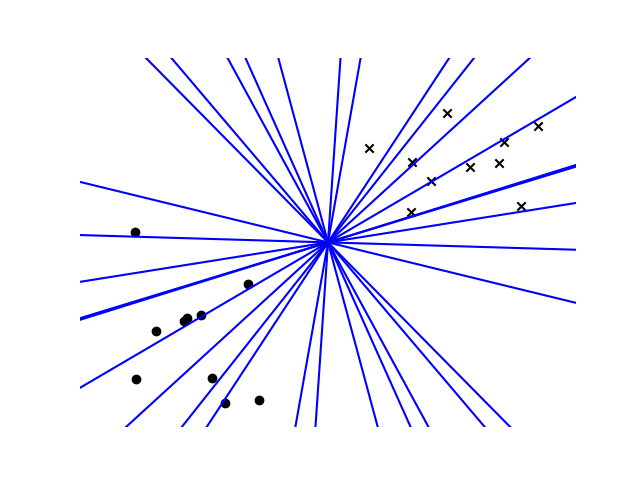

In [4]:
plt.figure()

[plot_line(l) for l in b]
plt.scatter(c1[0], c1[1], marker='x', color='black')
plt.scatter(c2[0], c2[1], marker='o', color='black')

plt.ylim(-10, 10)
plt.xlim(-10, 10)

plt.axis('off')
plt.show()

## Compute Hashes

With the data generated, we can compute the hashes. The hases are stored as standard Python byte arrays with each hyperplane controling a single bit. The hashes points from both clusters are printed in binary, which illustrates how different the hashes are for far away points.

In [5]:
c1_codes = [lsh.lsh(c, b) for c in c1.T]
c2_codes = [lsh.lsh(c, b) for c in c2.T]

print('Cluster 1')
for c in c1_codes:
    print(''.join(map('{:08b}'.format, c)))
    
print()      
print('Cluster 2')
for c in c2_codes:
    print(''.join(map('{:08b}'.format, c)))

Cluster 1
0100101010101101
0100101010101101
0100101010101101
0100101010101101
0100101010101101
0100101010001101
0110100010101101
0000101010011100
0100101010001100
0100101010001100

Cluster 2
1011010101010010
1011010101110011
1011010101110010
1001011100010110
1111010101100011
1011010101010010
1011010101010010
1011010101010010
1111010101100011
1011010101010010


## Rank

Finally, and without loss of generaality, we choose the first point in the "x" cluster to be our serarch target, and compute the hamming distance to every other point in both clusters. These distances are printed. Note that the clustering is easily apparent in the distances.

In [6]:
target = c1_codes[0]

c1_dist = [lsh.hamming_distance(h1=target, h2=c) for c in c1_codes]
c2_dist = [lsh.hamming_distance(h1=target, h2=c) for c in c2_codes]

print('Cluster 1 Distances')
for c in c1_dist:
    print(c)
    
print()
print('Cluster 2 Distances')
for c in c2_dist:
    print(c)
    
closest_ind = np.argmin(c1_dist[1:]) + 1
closest = c1[:, closest_ind]

c1_pruned = np.delete(c1, [0, closest_ind], axis=1)
c1_dist_pruned = np.delete(c1_dist, [0, closest_ind])

Cluster 1 Distances
0
0
0
0
0
1
2
4
2
2

Cluster 2 Distances
16
14
15
12
12
16
16
16
12
16


This effect can be visualized as well. In the figure below, distance corresponds to color, with a brighter color indicating a further distance with two exceptions. The target point (first point in the "x" cluster) is shown in red, and the closest match to it in the hashed space is shown in orange. Note that the algorithm is not perfect, especially with only 16 bits, and ties (hash collisions) are broken arbitrarily. 

<IPython.core.display.Javascript object>


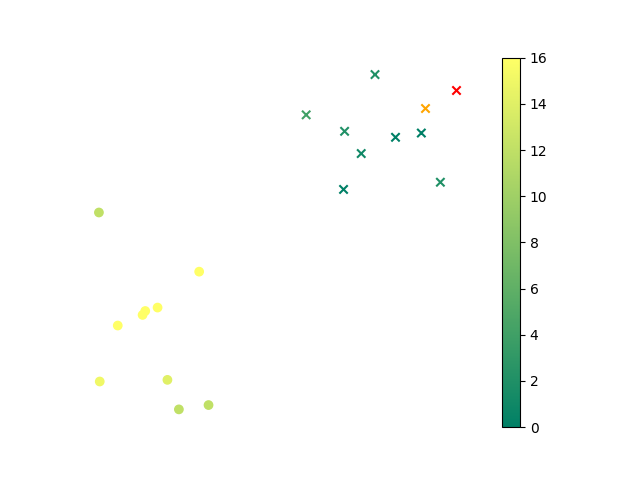

In [7]:
plt.figure()
cmap = plt.get_cmap('summer', 256)
plt.set_cmap(cmap)
plt.scatter(c1_pruned[0], c1_pruned[1], marker='x', c=c1_dist_pruned, cmap=cmap, vmin=0, vmax=hash_bits)
plt.scatter(c2[0], c2[1], marker='o', c=c2_dist, cmap=cmap, vmin=0, vmax=hash_bits)
plt.colorbar()
plt.scatter(c1[0,0], c1[1,0], marker='x', c='red')
plt.scatter(closest[0], closest[1], marker='x', c='orange')
plt.axis('off')
plt.show()